## Times Series
Using the following notebook
https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [23]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

time: 5.89 ms


In [24]:
get_ipython().magic('load_ext cellevents')

The cellevents extension is already loaded. To reload it, use:
  %reload_ext cellevents
time: 1.27 ms


In [25]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        epochs=1
        model.fit(X, y, epochs, batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size)
    return yhat[0,0]

time: 117 ms


In [26]:
# load dataset
# Data can be found here 
# https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line
# path = "/home/jd/data/webTraffic/"
series = read_csv(path+'shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

time: 2.89 ms


In [27]:
series

1-01
1-02    145.9
1-03    183.1
1-04    119.3
1-05    180.3
1-06    168.5
1-07    231.8
1-08    224.5
1-09    192.8
1-10    122.9
1-11    336.5
1-12    185.9
2-01    194.3
2-02    149.5
2-03    210.1
2-04    273.3
2-05    191.4
2-06    287.0
2-07    226.0
2-08    303.6
2-09    289.9
2-10    421.6
2-11    264.5
2-12    342.3
3-01    339.7
3-02    440.4
3-03    315.9
3-04    439.3
3-05    401.3
3-06    437.4
3-07    575.5
3-08    407.6
3-09    682.0
3-10    475.3
3-11    581.3
3-12    646.9
Name: 266.0, dtype: float64

time: 2.73 ms


In [28]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

time: 1.18 ms


In [29]:
raw_values

array([ 145.9,  183.1,  119.3,  180.3,  168.5,  231.8,  224.5,  192.8,
        122.9,  336.5,  185.9,  194.3,  149.5,  210.1,  273.3,  191.4,
        287. ,  226. ,  303.6,  289.9,  421.6,  264.5,  342.3,  339.7,
        440.4,  315.9,  439.3,  401.3,  437.4,  575.5,  407.6,  682. ,
        475.3,  581.3,  646.9])

time: 2.2 ms


In [30]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

time: 2.23 ms


In [31]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

time: 886 µs


In [32]:
train

array([[   0. ,   37.2],
       [  37.2,  -63.8],
       [ -63.8,   61. ],
       [  61. ,  -11.8],
       [ -11.8,   63.3],
       [  63.3,   -7.3],
       [  -7.3,  -31.7],
       [ -31.7,  -69.9],
       [ -69.9,  213.6],
       [ 213.6, -150.6],
       [-150.6,    8.4],
       [   8.4,  -44.8],
       [ -44.8,   60.6],
       [  60.6,   63.2],
       [  63.2,  -81.9],
       [ -81.9,   95.6],
       [  95.6,  -61. ],
       [ -61. ,   77.6],
       [  77.6,  -13.7],
       [ -13.7,  131.7],
       [ 131.7, -157.1],
       [-157.1,   77.8]])

time: 4.12 ms


In [33]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

time: 1.15 ms


In [36]:
# repeat experiment
repeats = 1
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 30, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    batch_size=1
    lstm_model.predict(train_reshaped, batch_size)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

1) Test RMSE: 93.272
time: 1min 39s


            rmse
count   1.000000
mean   93.271796
std          NaN
min    93.271796
25%    93.271796
50%    93.271796
75%    93.271796
max    93.271796


/home/jd/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


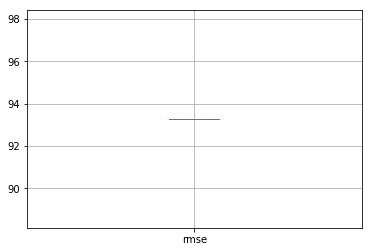

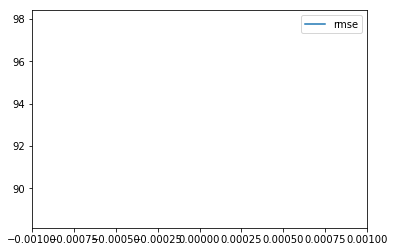

time: 216 ms


In [37]:
 # summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
results.plot()
pyplot.show()